In [190]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [191]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [192]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartition_v3.0/output_repar_test/'

In [193]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_test/


In [194]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [195]:
name_project_probes = info_basic['name_project_probes']
name_project_targets = info_basic['name_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, name_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, name_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-03/


In [196]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [197]:
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

In [198]:
dir_image = dir_project+info_basic['dir_image']
dir_disp_probes  = dir_project_probes + info_basic_probes['dir_disp'] 
print('dir_image: ', dir_image)
print('dir_disp: ', dir_disp_probes)

dir_image:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_test/image_test/
dir_disp:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/autopick17-01//


In [199]:
stalistname_all = info_basic_probes['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_all = stainfo['latitude'].tolist() 
lon_all = stainfo['longitude'].tolist()

In [200]:
stalistname = dir_project_probes+ info_basic_probes['stalistname']
stainfo_probes = pd.read_excel(stalistname,sheet_name=None)
stalistname = dir_project_targets+ info_basic_targets['stalistname']
stainfo_targets = pd.read_excel(stalistname,sheet_name=None)

In [201]:
loc_probes = pd.read_excel(dir_project_probes + 'subwork_location.xlsx',sheet_name='location')

In [202]:
f = info_basic_bi_probes['f']
c = np.linspace(info_basic_probes['c_min'],info_basic_probes['c_max'],info_basic_probes['c_num'])

In [203]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

### Cluster

In [204]:
phase_mean = info_basic_bi['phase_mean']
ks_f_range = info_basic['ks_f_range']
ks_f_range = [10,15]

In [205]:
def extract_probes(key_subwork):
    global dir_project
    global dir_project_probes
    global dir_project_targets
    global probes
    global stainfo_targets

    stas = stainfo_targets[key_subwork]['Station'].tolist()
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_targets[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [206]:
def find_nearest(lon_this,lat_this,lon_all,lat_all):
    lon_all = np.array(lon_all)
    lat_all = np.array(lat_all)
    lon_all = lon_all.reshape(-1,1)
    lat_all = lat_all.reshape(-1,1)
    dist = np.sqrt((lon_all-lon_this)**2+(lat_all-lat_this)**2)
    min_dist = np.min(dist)
    index = np.where(dist==min_dist)[0][0]
    return index

In [207]:
def cluster_filter(target):
    global flag_err
    global flag_plot
    global dir_image
    # extract all disp
    probes_this = extract_probes(target)
    stations = set()
    for probe in probes_this:
        stations_this = [station for station in stainfo_probes[probe]['Station'].tolist()]
        stations = stations.union(set(stations_this))
        
    stations = list(stations)

    lon_this = []
    lat_this = []
    for probe in probes_this:
        lon_this.append(loc_probes['lon_centroid'][probes.index(probe)])
        lat_this.append(loc_probes['lat_centroid'][probes.index(probe)])
    # 读取全部autopick dispersion curves
    disp_all = {}
    for probe in probes_this:
        file_ds = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
        disp = np.loadtxt(file_ds,delimiter=',')
        index = np.where((disp[:,0]>=ks_f_range[0]) & (disp[:,0]<=ks_f_range[1]))[0]
        disp_all[probe] = disp[index,:]
    phase_this = [phase_mean[probe] for probe in probes_this]

    # find central probe and cluster based on it
    lon_centroid = np.mean(lon_this)
    lat_centroid = np.mean(lat_this)
    index = find_nearest(lon_centroid,lat_centroid,lon_this,lat_this)
    c_ref = phase_this[index]
    probe_ref = probes_this[index]
    
    phase_sort = np.sort(phase_this)
    index_phase = range(len(phase_sort))
    probe_accept = []
    phase_accept = []
    lon_accept = []
    lat_accept = []
    for probe in probes_this:
        if phase_mean[probe] >= c_ref*(1-flag_err) and phase_mean[probe] <= c_ref*(1+flag_err):
            probe_accept.append(probe)
            lon_accept.append(loc_probes['lon_centroid'][probes.index(probe)])
            lat_accept.append(loc_probes['lat_centroid'][probes.index(probe)])
            phase_accept.append(phase_mean[probe])

    if flag_plot == 1:
        fig = plt.figure(figsize=(21,6))
        ax = fig.add_subplot(131)
        ax.scatter(index_phase,phase_sort,c='k',s=20)
        ax.axhline(y=c_ref,color='b',ls='--',label='central mean')
        ax.axhline(y=c_ref*(1-flag_err),color='r',ls='--',label='tolerance range')
        ax.axhline(y=c_ref*(1+flag_err),color='r',ls='--')
        ax.set_xlabel('probe index')
        ax.set_ylabel('phase velocity (km/s)')
        ax.legend()

        ax = fig.add_subplot(132)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_this,lat_this,c=phase_this,s=20,cmap='jet')
        ax.scatter(lon_centroid,lat_centroid,c='k',s=60,marker='*',label = 'centroid')
        #设置colorbar范围
        im.set_clim(vmin=min(phase_this),vmax=max(phase_this))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target)
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        fig.colorbar(im, ax=ax)
        ax.legend()
        """
        print('phase_max: ', max(phase_this))
        print('phase_min: ', min(phase_this))
        print('phase_bar: ', max(phase_this)-min(phase_this))
        print('phase_percent: ', (max(phase_this)-min(phase_this))/np.mean(phase_this)*100, '%')
        """
        ax = fig.add_subplot(133)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_accept,lat_accept,c=phase_accept,s=20,cmap='jet')
        ax.scatter(lon_centroid,lat_centroid,c='k',s=60,marker='*',label = 'centroid')
        im.set_clim(vmin=min(phase_this),vmax=max(phase_this))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target)
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        fig.colorbar(im, ax=ax)
        ax.legend()
        plt.tight_layout()
        plt.savefig(dir_image+'cluster_filter_'+target+'.png',dpi=100)
        #plt.close()
    print('cluster_filter: ', target)
    return probe_accept,lon_accept,lat_accept


In [208]:
probe_accept_all = {}
lon_accept_all = {}
lat_accept_all = {}

In [209]:
flag_err = 0.1
flag_plot = 0
for target in targets:
    probe_accept_all[target],lon_accept_all[target],lat_accept_all[target] = cluster_filter(target)

cluster_filter:  09-04
cluster_filter:  10-04
cluster_filter:  11-04
cluster_filter:  12-04
cluster_filter:  13-04
cluster_filter:  14-04


cluster_filter:  15-04
cluster_filter:  16-04
cluster_filter:  17-04
cluster_filter:  18-04
cluster_filter:  19-04
cluster_filter:  20-04
cluster_filter:  21-04
cluster_filter:  22-04
cluster_filter:  23-04
cluster_filter:  24-04
cluster_filter:  25-04
cluster_filter:  26-04
cluster_filter:  27-04
cluster_filter:  28-04
cluster_filter:  29-04
cluster_filter:  30-04
cluster_filter:  31-04
cluster_filter:  32-04
cluster_filter:  33-04
cluster_filter:  34-04
cluster_filter:  35-04
cluster_filter:  36-04
cluster_filter:  37-04
cluster_filter:  38-04
cluster_filter:  39-04
cluster_filter:  40-04
cluster_filter:  41-04
cluster_filter:  42-04
cluster_filter:  43-04
cluster_filter:  44-04
cluster_filter:  45-04
cluster_filter:  46-04
cluster_filter:  47-04
cluster_filter:  48-04
cluster_filter:  49-04
cluster_filter:  50-04
cluster_filter:  51-04
cluster_filter:  52-04
cluster_filter:  09-05
cluster_filter:  10-05
cluster_filter:  11-05
cluster_filter:  12-05
cluster_filter:  13-05
cluster_fil

### K-S analysis

In [ ]:
ds_probe_all = {}
for probe in info_basic_probes['key_subworks']:
    file_ds = dir_project_probes  + info_basic_probes['dir_ds'] + 'ds_'+probe+'.h5'
    ds = h5py.File(file_ds,'r')
    ds_probe_all[probe] = ds['ds_remove'][0]
    ds.close()

In [218]:
flag_pass = 0.3

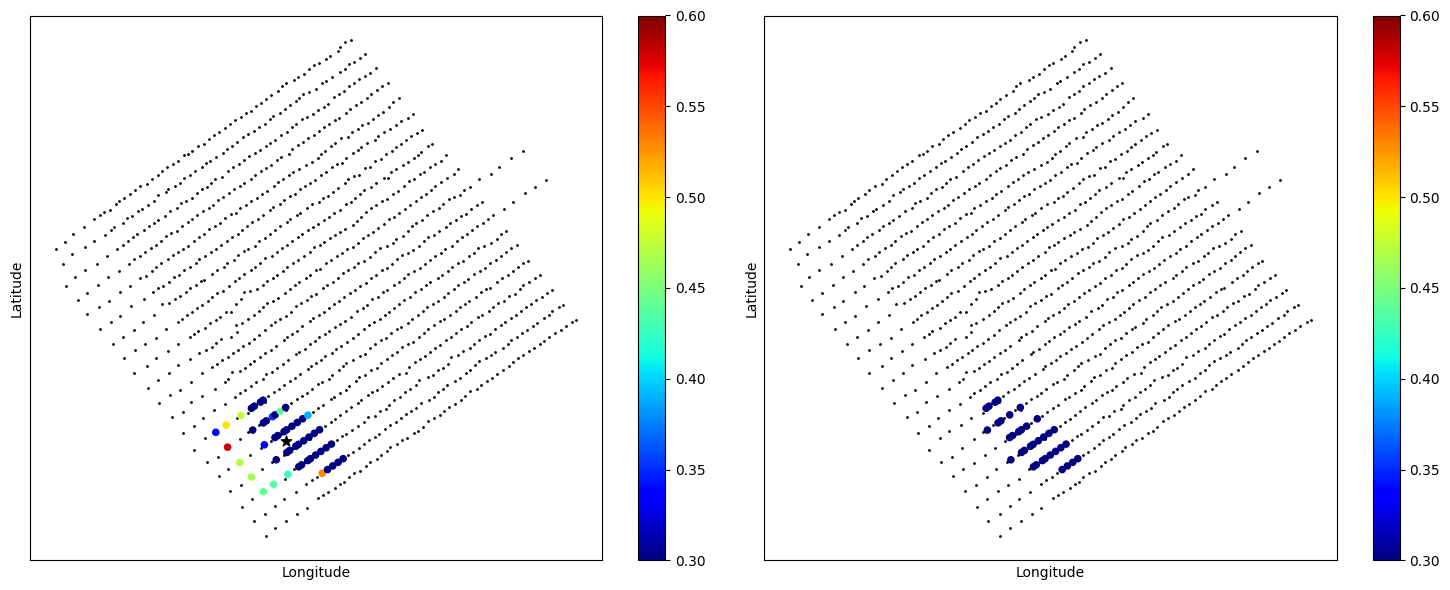

In [219]:
target = targets[1]
probe_accept = probe_accept_all[target]
lon_accept = lon_accept_all[target]
lat_accept = lat_accept_all[target]

lon_centroid = np.mean(lon_accept)
lat_centroid = np.mean(lat_accept)
index = find_nearest(lon_centroid,lat_centroid,lon_accept,lat_accept)
probe_ref = probe_accept[index]

f_sample = np.linspace(ks_f_range[0],ks_f_range[1],200,endpoint=False)
c_pick = {}
for probe in probe_accept:
    c_pick[probe] = []
    file_ds = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
    disp = np.loadtxt(file_ds,delimiter=',')
    index = np.where((disp[:,0]>=ks_f_range[0]) & (disp[:,0]<=ks_f_range[1]))[0]
    disp = disp[index,:]
    f_this = disp[:,0]
    c_this = disp[:,1]
    # 生成插值函数,可以外推
    f = interpolate.interp1d(f_this,c_this,kind='cubic')
    c_pick[probe] = f(f_sample)

f_pick_ref = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,0]
c_pick_ref0 = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,1]
f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic')
c_pick_ref = f(f_sample)

ks_p_values = []
ks_statistic = []
for probe in probe_accept:
    ks_p_values.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[1])
    ks_statistic.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[0])

index_pass = np.array(ks_statistic)<flag_pass
probe_pass = np.array(probe_accept)[index_pass]
lon_pass = np.array(lon_accept)[index_pass]
lat_pass = np.array(lat_accept)[index_pass]
ks_statistic_pass = np.array(ks_statistic)[index_pass]

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.scatter(lon_all,lat_all,c='k',s=1)
im = ax.scatter(lon_accept,lat_accept,c=ks_statistic,s=20,cmap='jet')
ax.scatter(lon_centroid,lat_centroid,c='k',s=60,marker='*',label = 'centroid')
plt.colorbar(im, ax=ax)
im.set_clim(vmin=flag_pass,vmax=0.6)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(122)
ax.scatter(lon_all,lat_all,c='k',s=1)
im = ax.scatter(lon_pass,lat_pass,c=ks_statistic_pass,s=20,cmap='jet')
im.set_clim(vmin=flag_pass,vmax=0.6)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(im, ax=ax)
plt.tight_layout()

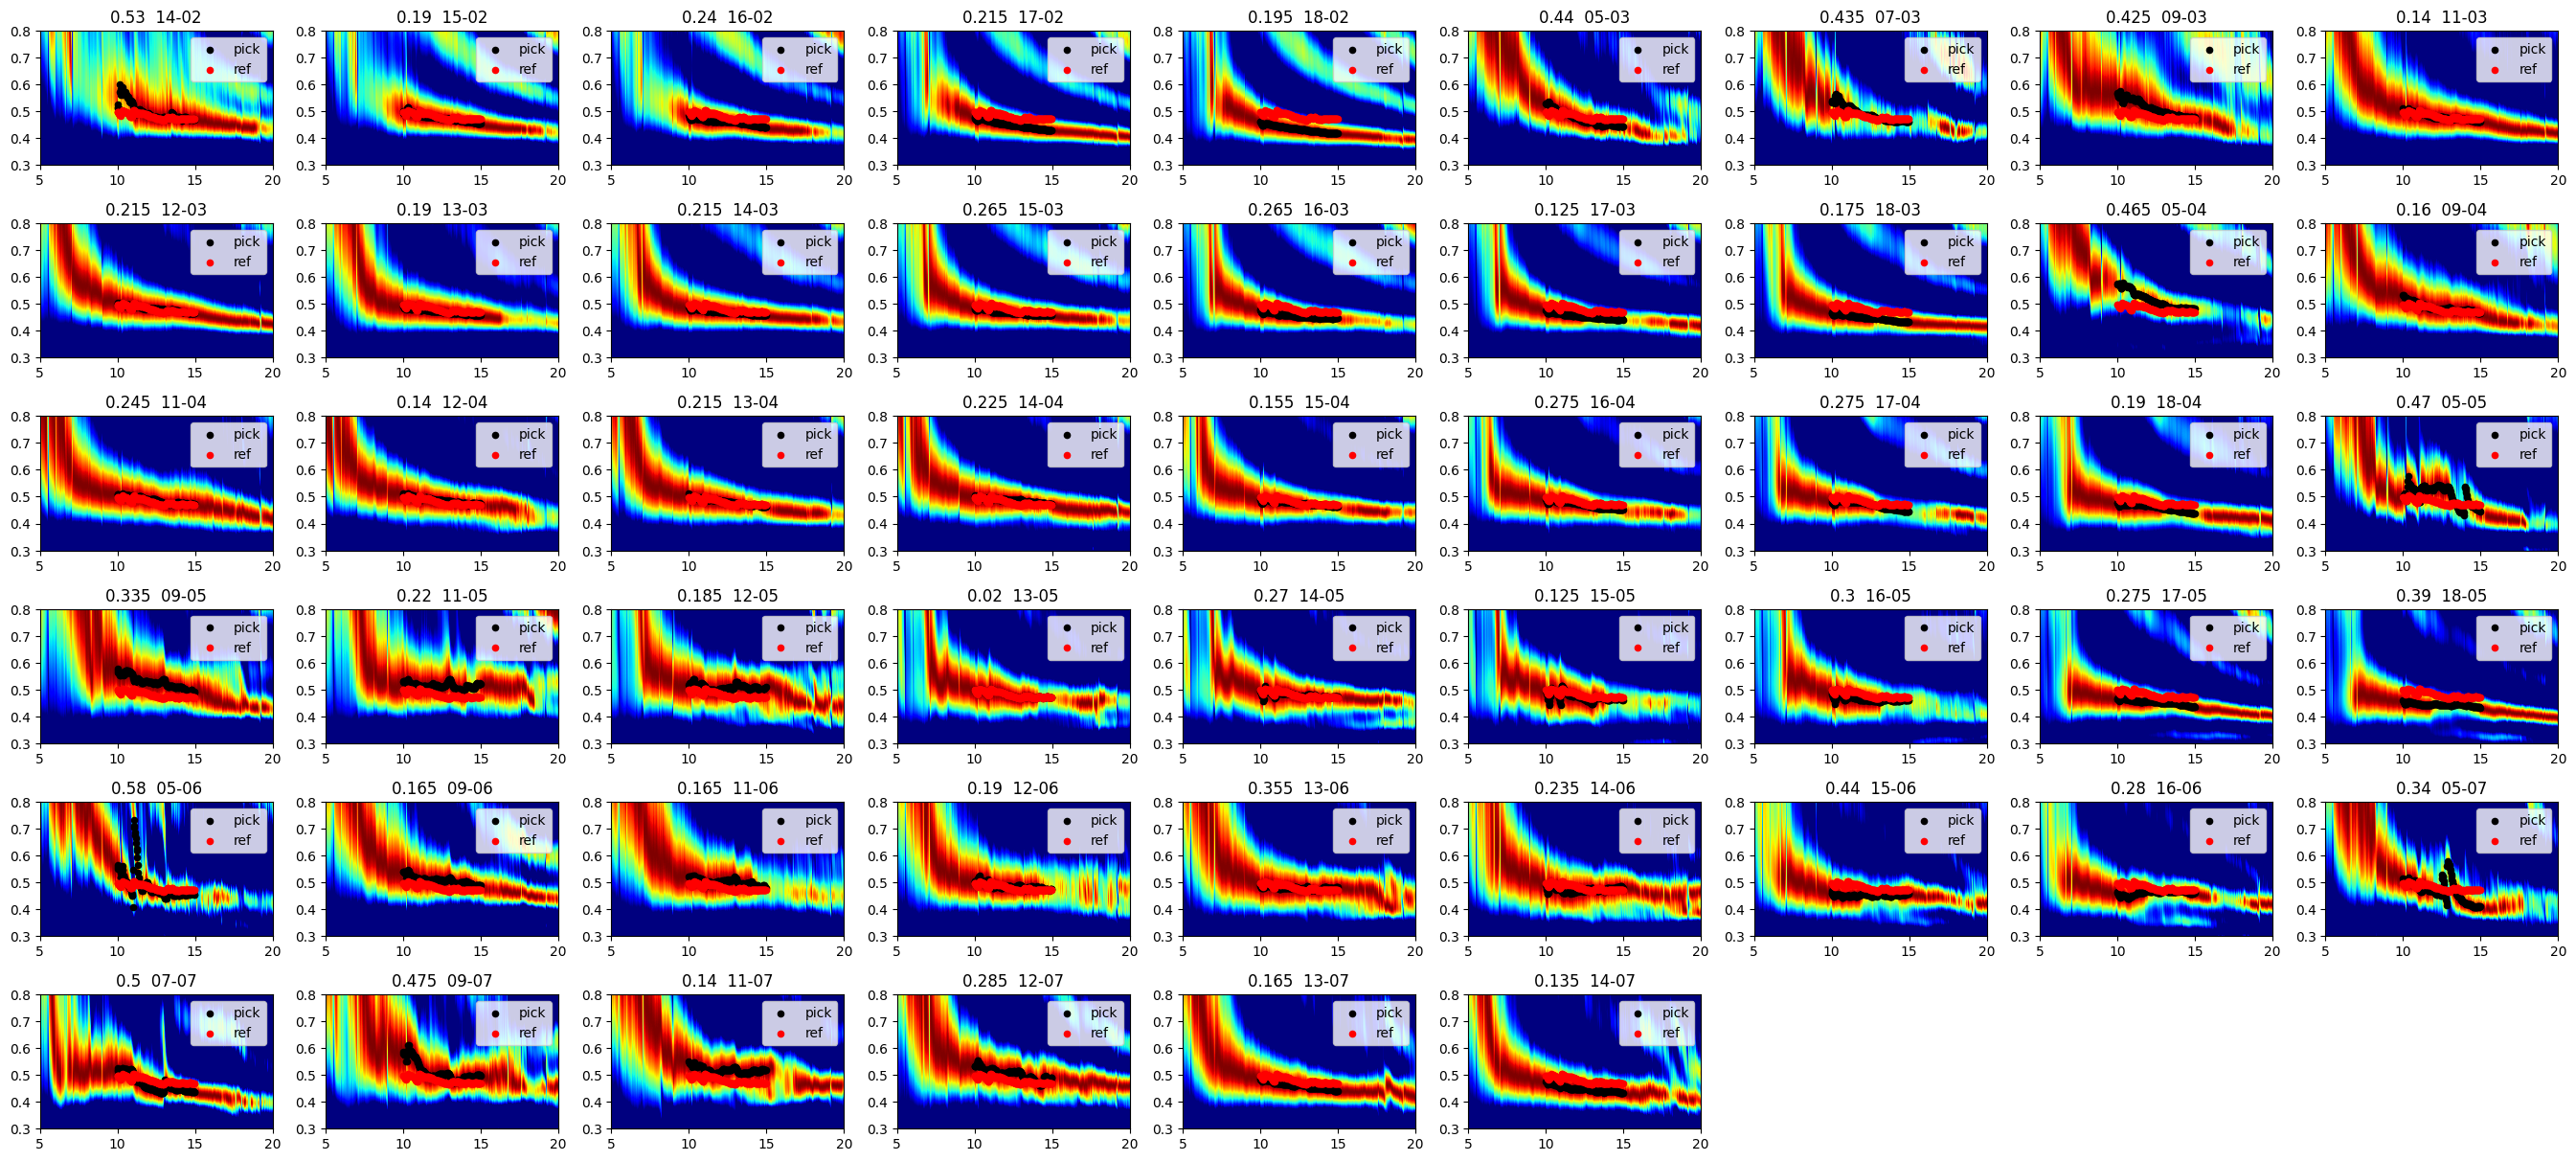

In [217]:
clim = [0.3,0.8]
flim = [5,20]
f = info_basic_bi_probes['f']
c = np.linspace(info_basic_probes['c_min'],info_basic_probes['c_max'],info_basic_probes['c_num'])
num = len(probe_accept)
n_cols = int(np.ceil(np.sqrt(num)))+1
n_rows = int(np.floor(np.sqrt(num)))
fig = plt.figure(figsize=(n_cols*3,n_rows*2))
for i in range(num):
    ax = plt.subplot(n_rows,n_cols,i+1)
    ax = plotlib.plot_fj(ax,ds_probe_all[probe_accept[i]],str(ks_statistic[i])+'  '+probe_accept[i],f,c,0,c_map='jet')
    ax.scatter(f_sample, c_pick[probe_accept[i]], s=20, c='k', marker='o', label='pick')
    ax.scatter(f_sample, c_pick_ref, s=20, c='r', marker='o', label='ref')
    ax.set_ylim(clim)
    ax.set_xlim(flim)
    ax.legend()
plt.tight_layout()